### test iML1515 （）E.coli in different meida


In [1]:
import os
import sys

# sys.path.append('../../code/Functions/')
sys.path.append('../Functions/')
import media
import pandas as pd
import cobra
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


get model and media tables

In [2]:
os.chdir('../../data/')
iML1515 = cobra.io.load_json_model('template_GEMs/iML1515_metacyc.json')
iML1515.solver = 'cplex'
# input_file = 'media/metacyc_growth_media_composition_df.tsv'
iML1515.reactions.get_by_id('EX_o2_e').lower_bound = 0
input_file = 'media/metacyc_growth_media_composition_df_trimed.tsv'
media_df = pd.read_csv(input_file, sep='\t', header=0, index_col=0)

output_file = 'media_model_m2.json'

Using license file /Users/lhao/gurobi.lic
Academic license - for non-commercial use only


there are some essential substrates like:

    ['EX_pi_e','EX_mn2_e','EX_glc__D_e','EX_zn2_e','EX_mg2_e','EX_ca2_e','EX_ni2_e','EX_cu2_e','EX_cobalt2_e','EX_mobd_e','EX_so4_e','EX_nh4_e','EX_k_e','EX_cl_e']
     
can't be 0


In [3]:
model_i = iML1515.copy()
essential_rxns = []
for rxn in model_i.medium:
    with model_i:
        model_i.reactions.get_by_id(rxn).lower_bound = 0
        f = model_i.optimize().objective_value
        if f < 1e-6 or model_i.solver.status != 'optimal':
            essential_rxns.append(rxn)
print(essential_rxns, )
essential_rxns = ['EX_glc__D_e',]
essential_rxns = ['',]

/Users/lhao/opt/anaconda3/lib/python3.7/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


['EX_pi_e', 'EX_fe3_e', 'EX_mn2_e', 'EX_glc__D_e', 'EX_zn2_e', 'EX_mg2_e', 'EX_ca2_e', 'EX_ni2_e', 'EX_cu2_e', 'EX_cobalt2_e', 'EX_mobd_e', 'EX_so4_e', 'EX_nh4_e', 'EX_k_e', 'EX_cl_e']


loop test every media


In [4]:
# media_name_i = 'LAB'
# media_name = 'Concentration_' + media_name_i

media_name_dic = \
    {
     'M1: dGMM': 'M1',
     'M2: LAB': 'M2',
     'M3: dGMM+LAB': 'M3',
     'M4: dGMM+LAB low M/V': 'M4',
     'M5: dGMM+LAB exclude SCFA': 'M5',
     'M7: dGMM+LAB only monosacharides': 'M7',
     'M8: dGMM+LAB plus Mucin': 'M8',
     'M9: dGMM+LAB only Mucin': 'M9',
     'M10: dGMM+LAB 10% aminoacids': 'M10',
     'M11: dGMM+LAB excluding aromatic AA': 'M11',
     'M13: B.thetaiotaomicron MM': 'M13',
     'M14: C.perfiringens MM': 'M14',
     'M15A: E.coli MM1': 'M15A',
     'M15B: E.coli MM2': 'M15B',
     'M16: V.parvula defined medium': 'M16',
     'GMM: GMM': 'GMM',
     'mGAM: mGAM': 'mGAM',
     'BHI++: brain heart infusion': 'BHI++',
     'WCA: WCA': 'WCA'}

media_name_list = list(media_name_dic.keys())

# media_name_list = ['M10: dGMM+LAB 10% aminoacids', 'M4: dGMM+LAB low M/V',
#        'M9: dGMM+LAB only Mucin', 'BHI++: brain heart infusion',
#        'M3: dGMM+LAB', 'mGAM: mGAM', 'M2: LAB', 'M5: dGMM+LAB exclude SCFA',
#        'M8: dGMM+LAB plus Mucin', 'M13: B.thetaiotaomicron MM',
#        'M11: dGMM+LAB excluding aromatic AA', 'M15A: E.coli MM1', 'WCA: WCA',
#        'M7: dGMM+LAB only monosacharides', 'GMM: GMM', 'M15B: E.coli MM2',
#        'M16: V.parvula defined medium', 'M1: dGMM', 'M14: C.perfiringens MM']
result = {}
for media_name in media_name_list:
    print(media_name)
    model_i = iML1515.copy()
    # f0 = model_i.optimize().objective_value
    print(model_i.optimize())
    # model_i.reactions.EX_glc__D_e.lower_bound = 0

    media_df_temp = media_df.copy()
    media_df_temp['Constituents'] = media_df_temp['metacyc_id']

    media_i_df = media_df_temp[
        ['Constituents', media_name, 'exchange_rxns', 'transport_rxns']]  # select M2 columns

    media_i_df.columns = ['Constituents', 'Concentration', 'exchange_rxns', 'transport_rxns']
    media_i_dic = media.get_media_dic_form_df(media_i_df, media_name)
    keys = list(media_i_dic.keys())
    for k in keys:
        v = media_i_dic[k]
        if v[1] in essential_rxns:
            # pass
            media_i_dic.pop(k, None)

    media_model = media.update_media_from_dic(model_i, media_i_dic)

    ff = media_model.optimize().objective_value
    result[media_name] = ff
    print(ff, '\n\n')

# # %%
# model_i = iML1515.copy()
# print(model_i.optimize())
# media_i_dic = {'D-Glucose': [28.0, 'EX_glc__D_e', ''],
#                'CO+2': [0.0043384, 'EX_cobalt2_e', 'CITt13'],
#                'SELENITE': [0.0, 'EX_slnt_e', ''],
#                'FE+3': [0.0, 'EX_fe3_e', 'FEDCabc; FE3t'],
# 
#                }
# 
# media_model = media.update_media_from_dic(model_i, media_i_dic)
# media_model.reactions.EX_ni2_e.lower_bound = -1000
# media_model.reactions.EX_k_e.lower_bound = -1000
# 
# print(media_model.optimize(), )


M1: dGMM
<Solution 0.158 at 0x7fb8a1a55b10>
new transport reaction added TRANS_fru: fru_c <=> fru_e
new transport reaction added TRANS_D-LACTATE: D-LACTATE_c <=> D-LACTATE_e
new transport reaction added TRANS_ASCORBATE: ASCORBATE_c <=> ASCORBATE_e
new transport reaction added TRANS_ADENOSYLCOBALAMIN: ADENOSYLCOBALAMIN_c <=> ADENOSYLCOBALAMIN_e
new transport reaction added TRANS_BIOTIN: BIOTIN_c <=> BIOTIN_e
new transport reaction added TRANS_BUTYRIC_ACID: BUTYRIC_ACID_c <=> BUTYRIC_ACID_e
new transport reaction added TRANS_CL-: CL-_c <=> CL-_e
new transport reaction added TRANS_GLUTATHIONE: GLUTATHIONE_c <=> GLUTATHIONE_e
new transport reaction added TRANS_Pi: Pi_c <=> Pi_e
new transport reaction added TRANS_PUTRESCINE: PUTRESCINE_c <=> PUTRESCINE_e
new transport reaction added TRANS_PYRIDOXAL: PYRIDOXAL_c <=> PYRIDOXAL_e
new transport reaction added TRANS_PYRIDOXAMINE: PYRIDOXAMINE_c <=> PYRIDOXAMINE_e
new transport reaction added TRANS_PYRIDOXINE: PYRIDOXINE_c <=> PYRIDOXINE_e
new tr

load experiment data and plot

In [5]:


result_df = pd.DataFrame([result, media_name_dic])
result_df.columns = result_df.iloc[1]
result_df = result_df.drop(1)
result_df['designation in screen'] = 'iML1515'

experiment_db = pd.read_excel(r'media/NatureMicrobiology2018.3.514–522.xlsx', sheet_name='S4. Growth matrix')
experiment_db = experiment_db[experiment_db['designation in screen'].str.contains('E. coli')]
experiment_db = experiment_db.append(result_df)

experiment_db = experiment_db.set_index(['designation in screen'])

temp_df = experiment_db 
# temp_df.where((temp_df!='0' and temp_df!=0),temp_df) = 1
# temp_df[(temp_df != '0' | temp_df != 0)]
temp_df = temp_df.replace(to_replace=r'\(.', value=1, regex=True)
temp_df = temp_df.where(temp_df<1,1)


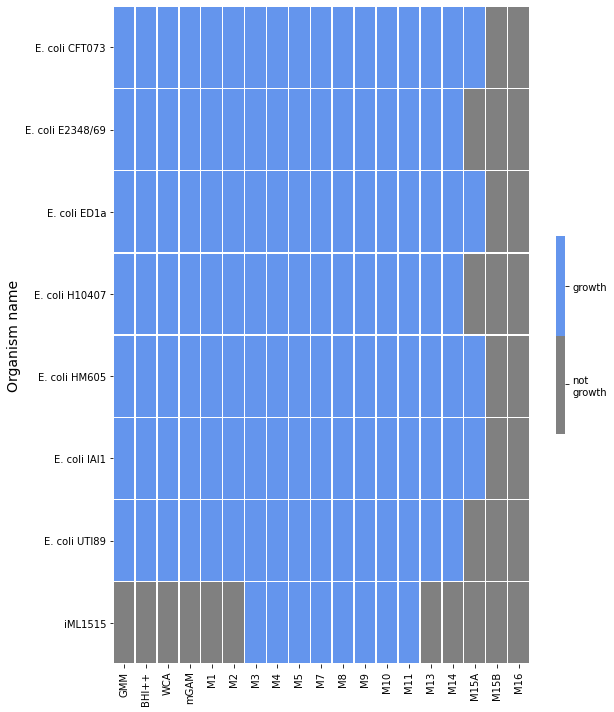

In [6]:
import matplotlib.colors as mcolors
cmap, norm = mcolors.from_levels_and_colors([0, 0.5, 1], ['grey','CornflowerBlue' ])
# plt.pcolor(temp_df)

plt.figure(figsize=(9, 10))
ax = sns.heatmap(temp_df,cmap=cmap, linewidths=0.5, cbar_kws={"shrink": .30})
ax.set_ylabel('Organism name', fontsize=14)

plt.yticks(np.arange(0.5, len(temp_df.index), 1), temp_df.index, fontsize=10)
plt.xticks(np.arange(0.5, len(temp_df.columns), 1), temp_df.columns)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.25, .75, ])
cbar.set_ticklabels(['not\ngrowth', 'growth'])
plt.tight_layout()
plt.show()
plt.close()
